In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import jaccard

In [3]:
########## IMPORTING THE DATASET ##########

### Import our game list dataset ###

df_games = pd.read_csv('data/games.csv')
# We keep only the id and the name of the game, we do not use the others information in this project
df_games = df_games[["app_id", "title"]]
print("We have a list of "+str(len(df_games))+ " games !")

### Add the tags to the dataset (tags) ###

# The data is from the following Kaggle dataset : https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam?select=games_metadata.json
# We isolated manually the 'app_id' and the 'tags' from the JSON file putting separators and using Excel to convert it into a CSV file

#Read the input CSV file
df_tags = pd.read_csv('data/game_tags.csv', ';')
# Adding the tags to the initial game list
df_tags = pd.merge(df_tags, df_games, "inner", "app_id")

df_tags.head() # When we want to use our dataset, we call 'df_tags' from now.

We have a list of 48353 games !


C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_2732\2914503509.py:16: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_tags = pd.read_csv('data/game_tags.csv', ';')


,app_id,tags,title
0,10090,"Zombies,World War II,FPS,Multiplayer,Action,Sh...",Call of Duty: World at War
1,13500,"Action,Adventure,Parkour,Third Person,Great So...",Prince of Persia: Warrior Within™
2,22364,Action,BRINK: Agents of Change
3,113020,"Co-op,Stealth,Indie,Heist,Local Co-Op,Strategy...",Monaco: What's Yours Is Mine
4,226560,"Zombies,Adventure,Survival,Action,Third Person...",Escape Dead Island


In [4]:
########## PRE-PROCESSING OF THE DATA ##########

# If the final file of the preprocessing part exists, skip this part
# The preprocessing takes around 10min and must be done only once

execute_preprocessing = True

if (os.path.isfile("data/matrix_game_tags.csv")):
    execute_preprocessing = False

print(execute_preprocessing)

False


In [5]:
if (execute_preprocessing) :

    ### PRE-PROCESSING (part 1) ###
    # -> Extract the list of unique game tags

    #Select tags from the dataframe and transform the strings into lists
    df_tags_string = df_tags['tags'].str.split(',')

    #Split tags into one row for each, we delete duplicate values
    df_tags_list = df_tags_string.explode().drop_duplicates()

    #We extract the result
    list_tags = df_tags_list.tolist()

    #Save the result in a file (optional)
    with open('data/unique_tags_list.txt', 'w') as output_file:
            for tag in list_tags:
                output_file.write(str(tag) + '\n')

    ### PRE-PROCESSING (part 2) ###
    # -> Create the game matrix (filled with 0) where each row is a game and the colomns are all the unique game tags (matrix size~ 47456 x 442)

    game_tag_matrix = pd.DataFrame("0", index=df_tags['app_id'], columns=list_tags)


    ### PRE-PROCESSING (part 3) ###
    # -> For each games, read its tags, and put a 1 in the corresponding colomn

    for index, row in df_tags.iterrows(): 
        app_id = row["app_id"]
        app_tags = str(row["tags"]).split(',')
        for tag in app_tags:
            game_tag_matrix.loc[app_id, tag] = "1"

    game_tag_matrix = game_tag_matrix.drop(["nan"], axis=1)

    game_tag_matrix.to_csv('data/matrix_game_tags.csv', encoding='utf-8')
    #=> We can now use the 'game_tag_matrix' for the dimentionality reduction !

    # Note : We can ignore the game that have only the tag 'nan'

else:
     print("The preprocessing have been skipped: The result file (matrix_game_tags.csv) already exist.\n If you want to regenerate the file, delete it and re-execute the code.")

The preprocessing have been skipped: The result file (matrix_game_tags.csv) already exist.
 If you want to regenerate the file, delete it and re-execute the code.


In [6]:
# Verification of the tag list in matrix.csv
list_tags_matrix = "app_id,Zombies,World War II,FPS,Multiplayer,Action,Shooter,Co-op,Singleplayer,Moddable,First-Person,War,Online Co-Op,Gore,Historical,Classic,Survival,Great Soundtrack,Tanks,Horror,Adventure,Parkour,Third Person,Platformer,Time Travel,Atmospheric,Hack and Slash,Time Manipulation,Fantasy,Story Rich,Dark,Open World,Controller,Dark Fantasy,Puzzle,Stealth,Indie,Heist,Local Co-Op,Strategy,Top-Down,Crime,Casual,Pixel Graphics,Local Multiplayer,2D,Loot,Cartoony,Survival Horror,Third-Person Shooter,Anime,Roguelike,Tower Defense,RPG,Sci-fi,Dungeon Crawler,Perma Death,Procedural Generation,Resource Management,Difficult,Roguelite,Replay Value,Arcade,Side Scroller,Retro,Shoot 'Em Up,Old School,Nostalgia,Comedy,Action RPG,Magic,Female Protagonist,Nudity,Action-Adventure,Medieval,Sandbox,Simulation,Character Customization,Horses,Realistic,Early Access,RTS,JRPG,Cute,Funny,Turn-Based,Visual Novel,Turn-Based Combat,Memes,Tactical,LEGO,Family Friendly,Split Screen,3D Platformer,Grand Strategy,Relaxing,Physics,Ambient,Minimalist,Space,Science,Education,Flight,Isometric,CRPG,Violent,Exploration,Mystery,Walking Simulator,Short,Psychological Horror,Post-apocalyptic,Addictive,Dark Humor,Building,Action Roguelike,Metroidvania,Otome,Dating Sim,Romance,Choices Matter,1990's,Free to Play,Mechs,Robots,Massively Multiplayer,PvP,Team-Based,Utilities,Software,Voxel,Point & Click,Alternate History,Drama,Hidden Object,LGBTQ+,MOBA,Fighting,Action RTS,Soundtrack,Turn-Based Strategy,City Builder,Cartoon,Turn-Based Tactics,Rhythm,Music,Cyberpunk,Episodic,Futuristic,Kickstarter,Choose Your Own Adventure,Twin Stick Shooter,4 Player Local,Top-Down Shooter,Political,Fast-Paced,Puzzle Platformer,Surreal,Abstract,Philosophical,Psychedelic,Psychological,Supernatural,2.5D,Multiple Endings,2D Platformer,Narrative,Cats,Score Attack,Remake,Linear,Sports,Party-Based RPG,Cult Classic,Steampunk,Racing,Automobile Sim,Destruction,Driving,Open World Survival Craft,Crafting,Base Building,Aliens,4X,Management,Time Management,Real Time Tactics,Blood,Hand-drawn,Text-Based,Interactive Fiction,Political Sim,Runner,Bikes,Motorbike,Emotional,VR,Detective,Dark Comedy,Mature,Baseball,Football (Soccer),Strategy RPG,Tactical RPG,Colorful,Grid-Based Movement,Sexual Content,Minigames,Beautiful,Animation & Modeling,Design & Illustration,Game Development,3D,3D Vision,3D Fighter,Boxing,Co-op Campaign,Real-Time,Ninja,Souls-like,Gothic,Satire,Board Game,Chess,2D Fighter,Competitive,Pool,Snooker,Naval Combat,Pirates,Naval,Trading,Sailing,Economy,MMORPG,Thriller,Trivia,Party,Party Game,Video Production,Military,Wargame,Combat,Foreign,Lovecraftian,FMV,Noir,Dystopian,Cold War,Mod,Snow,Narration,Modern,Underwater,Spectacle fighter,Fishing,Mythology,NSFW,Illuminati,Demons,Assassin,Audio Production,Battle Royale,God Game,Epic,Faith,Colony Sim,RPGMaker,Level Editor,Stylized,Trains,Diplomacy,Character Action Game,Life Sim,Nonlinear,Collectathon,Transportation,Immersive Sim,Dungeons & Dragons,Hacking,Dragons,PvE,Cinematic,Arena Shooter,Clicker,Parody,GameMaker,Card Game,Asynchronous Multiplayer,Asymmetric VR,Martial Arts,Villain Protagonist,Word Game,Medical Sim,Bullet Hell,Capitalism,Lore-Rich,Experience,Immersive,Swordplay,Roguelike Deckbuilder,Card Battler,Deckbuilding,Escape Room,Investigation,Tabletop,Hentai,6DOF,Idler,Job Simulator,Logic,Offroad,ATV,0TrackIR,Dynamic Narration,Pinball,Real-Time with Pause,Wrestling,Mouse only,Superhero,1980s,Match 3,Beat 'em up,Based On A Novel,Dinosaurs,Conversation,Tutorial,Comic Book,Programming,Nature,Submarine,Farming Sim,Vampire,Mining,Automation,Touch-Friendly,Cooking,On-Rails Shooter,Bullet Time,Gun Customization,Sniper,Outbreak Sim,Silent Protagonist,Auto Battler,Dog,Western,Artificial Intelligence,Rock Music,Politics,Crowdfunded,Photo Editing,Solitaire,Gambling,Combat Racing,Vehicular Combat,Hex Grid,Vikings,Precision Platformer,Transhumanism,Shop Keeper,Wholesome,Agriculture,Experimental,Social Deduction,Spelling,Basketball,Golf,Class-Based,Sequel,Movie,Unforgiving,Creature Collector,Rome,360 Video,Time Attack,Music-Based Procedural Generation,America,Looter Shooter,Motocross,Inventory Management,eSports,Werewolves,Space Sim,Conspiracy,Typing,Jet,Games Workshop,Warhammer 40K,Trading Card Game,Hunting,Mystery Dungeon,Underground,Mini Golf,Traditional Roguelike,Sokoban,Web Publishing,Jump Scare,Cozy,Hero Shooter,Gaming,Spaceships,Football (American),Skiing,Mars,Well-Written,World War I,Software Training,Tennis,Archery,Cycling,BMX,Quick-Time Events,Electronic Music,Boss Rush,Skateboarding,Skating,Voice Control,Instrumental Music,Electronic,Snowboarding,Documentary,Roguevania,Farming,Intentionally Awkward Controls,Bowling,Lemmings,Musou,Hobby Sim,Volleyball,Hardware,Cricket,Mahjong,Reboot,Benchmark,Feature Film,Steam Machine,Hockey,8-bit Music,Rugby,Tile-Matching,Coding,Fox,nan"
list_tags_matrix_split = list_tags_matrix.split(',')
print("nb_columns = "+str(len(list_tags_matrix_split))) # There are 442 different tags + the app_id column

# The test is valid if :
#   nb_columns = 443

nb_columns = 443


In [38]:
##### IMPLEMENTING THE NECESSARY FUNCTIONS FOR THE DIMENTIONALITY REDUCTION #####

def kmeans(data, k, max_iters=100):
    # Initialize centroids randomly
    centroids = data[np.random.choice(data.shape[0], k, replace=False), :]

    for _ in range(max_iters):
        # Calculate distances between data points and centroids
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)

        # Assign each data point to the nearest centroid
        cluster_assignments = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([data[cluster_assignments == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return cluster_assignments


# df_game_tags_binary = pd.read_csv('data/game_tags_binary.csv', index_col='Unnamed: 0')
# df_game_tags_binary.head()
# # # Convert DataFrame to NumPy array
# data = df_game_tags_binary.to_numpy()

# # Apply K-means clustering
# k = 2
# cluster_assignments = kmeans(data, k)

# # Replace the original features with the cluster assignments
# reduced_data = np.zeros_like(data)
# reduced_data[:, 0] = cluster_assignments

# # Convert the reduced data back to a DataFrame
# reduced_df = pd.DataFrame(reduced_data, index=df_game_tags_binary.index)

# # Save the reduced DataFrame to a CSV file
# reduced_df.to_csv('reduced_game_tags_kmeans.csv')

def power_iteration(A, num_iter=1000):
    b = np.random.rand(A.shape[1])

    for _ in range(num_iter):
        b = np.dot(A, b)
        b = b / np.linalg.norm(b)

    return b


def svd_basic(A, num_components, num_iter=1000):
    U = np.zeros((A.shape[0], num_components))
    S = np.zeros(num_components)
    Vt = np.zeros((num_components, A.shape[1]))

    for i in range(num_components):
        # Compute the matrix B
        B = np.dot(A.T, A)

        # Find the eigenvector with the largest eigenvalue using the power iteration method
        v = power_iteration(B, num_iter)
        Vt[i, :] = v

        # Find the corresponding singular value
        singular_value = np.sqrt(np.dot(v, np.dot(B, v)))
        S[i] = singular_value

        # Find the corresponding left singular vector
        u = np.dot(A, v) / singular_value
        U[:, i] = u

        # Deflate the matrix A
        A = A - singular_value * np.outer(u, v)

    return U, S, Vt

def svd_reduction(df, num_components, std_multiplier):
    # Convert DataFrame to NumPy array
    data = df.to_numpy()

    # Calculate the mean of each column
    column_mean = np.mean(data, axis=0)

    # Center the data by subtracting the mean
    centered_data = data - column_mean

    # Compute the SVD using the basic SVD implementation
    U, S, Vt = svd_basic(centered_data, num_components)

    # Select the number of principal components
    U_reduced = U[:, :num_components]
    S_reduced = np.diag(S[:num_components])

    # Reconstruct the reduced data
    reduced_data = np.dot(U_reduced, S_reduced)

    # Flip the sign of the second column if necessary
    if reduced_data[0, 1] > 0:
        reduced_data[:, 1] = -reduced_data[:, 1]

    # Calculate the standard deviation of each column
    std_devs = np.std(reduced_data, axis=0)

    # Apply the threshold based on the standard deviation
    for i in range(reduced_data.shape[1]):
        threshold = std_multiplier * std_devs[i]
        reduced_data[:, i] = np.where(np.abs(reduced_data[:, i]) > threshold, 1, 0).astype(np.int8)

    # Get the two highest loadings in the first two principal components
    columns_array = np.array(df.columns)
    top_tags = columns_array[np.argsort(-np.abs(Vt[:num_components, :]))[:, :num_components]]

    # Create column names based on the top tags
    column_names = [', '.join(tags) for tags in top_tags]

    # Convert the reduced data back to a DataFrame
    reduced_df = pd.DataFrame(reduced_data, index=df.index, columns=column_names)

    return reduced_df


def find_similar_games(df, input_app_id, threshold):
    # Get the row corresponding to the input app_id
    input_vector = df.loc[df['app_id'] == input_app_id].drop('app_id', axis=1).values[0]
    
    # Initialize the output list
    similar_games = []
    
    # Compare the input vector to each row in the DataFrame
    for index, row in df.iterrows():
        compare_app_id = row['app_id']
        compare_vector = row.drop('app_id')
        
        # Compute the Jaccard distance
        distance = jaccard(input_vector, compare_vector)
        
        if distance <= 1 - threshold: # We accept only the games that have a small jaccard distance (limit defined by the threshold)
            similar_games.append(compare_app_id)
    
    return similar_games



##### VISUALIZATION FUNCTIONS #####


# This methods allows us to vizualise the number of ones after applying the SVD, 
# using different standard divisations as threshold for converting the singular values matrix into a binary matrix.
def compare_std_deviations(df, num_components):
    counts_std = {}

    # For 1st, 2nd, and 3rd standard deviations
    for std_multiplier in range(1, 4):

        df_svd = svd_reduction(df, num_components, std_multiplier)
        
        # We count the number of zeros and non-zeros in the result
        counts = (df_svd == 0).sum().sum(), (df_svd != 0).sum().sum()
        counts_std[std_multiplier] = counts

    # Create a plot to diplay the results
    counts_df = pd.DataFrame(counts_std, index=['Zeros', 'Non-zeros'])    
    counts_df.T.plot(kind='bar', stacked=True)
    plt.xlabel('Standard deviation multiplier')
    plt.ylabel('Count')
    plt.title('Number of zeros and non-zeros for different standard deviation multipliers')
    plt.show()


# We use this method to analyse what is the best number of tags to merge into one concept.
# For this, we do a visualisation of the number of similar games for power of 2 components in a concept.
# Note that this vizualisation applies for only the input games with all the determined parameters
def compare_components(df,df_with_app_id, app_id, threshold, std_multiplier):
    component_counts = []
    num_similar_games = []
    max_power = 10

    for i in range(1, max_power+1):
        num_components = 10 * i

        # Appying the SVD and the find the similar games with number of components
        reduced_df = svd_reduction(df, num_components, std_multiplier)
        reduced_df = reduced_df.join(df_with_app_id)
        similar_games = find_similar_games(reduced_df, app_id, threshold)

        # Add the number of similar games to the list
        component_counts.append(num_components)
        num_similar_games.append(len(similar_games))
        
        # We add some separators to better readability of the visualization
        plt.axvline(x=num_components, color='r', linestyle='--')
        plt.ylim(bottom=0, top=50)

    plt.plot(component_counts, num_similar_games)
    plt.xlabel('Number of Components')
    plt.ylabel('Number of Similar Games')
    plt.title('Number of Similar Games for Different Numbers of Components')
    plt.show()

# We use this method to analyse what is the best number of tags to merge into one concept.
# For this, we do a visualisation of the number of similar games for power of 2 components in a concept.
# Note that this vizualisation applies for only the input games with all the determined parameters
def compare_threshold(df_svd, app_id, num_components):
    threshold_counts = []
    num_similar_games = []
    max_power = 10

    for i in range(3, max_power+1):
        threshold = 0.1 * i

        # Appying the SVD and the find the similar games with number of components
        similar_games = find_similar_games(df_svd, app_id, threshold)

        # Add the number of similar games to the list
        threshold_counts.append(threshold)
        num_similar_games.append(len(similar_games))
        
        # We add some separators to better readability of the visualization
        plt.axvline(x=threshold, color='r', linestyle='--')
        plt.ylim(bottom=0, top=50)

    plt.plot(threshold_counts, num_similar_games)
    plt.xlabel('Threshold')
    plt.ylabel('Number of Similar Games')
    plt.title('Number of Similar Games for Different Jaccard distance Threshold')
    plt.show()

In [35]:
########## EXECUTION OF DIMENSIONALITY REDUCTION USING SVD ##########

# We load the preprocessed matrix
df_game_tags_binary = pd.read_csv('data/matrix_game_tags.csv')
df_app_id = df_game_tags_binary[['app_id']] #We save the app_id column...
df_game_tags_binary = df_game_tags_binary.drop(['app_id'], axis=1) #... and then remove it for the SVD process
print("Numbers of tags :")
print(len(df_game_tags_binary.columns))

### Parameters of the SVD ###
num_components = 30 # From our visualisation
std_multiplier = 2 # From our visualisation, we take the 2nd standard devation to reduce the number of ones

df_svd = svd_reduction(df_game_tags_binary, num_components, std_multiplier)

# We add the app_id column again in as first column
# We can do this because the games stay in the same order
df_svd = df_svd.join(df_app_id)
df_svd = df_svd[['app_id'] + [col for col in df_svd.columns if col != 'app_id']]

# Save the result in csv file
df_svd.to_csv('results/reduced_game_tags_svd.csv')

Numbers of tags :
442


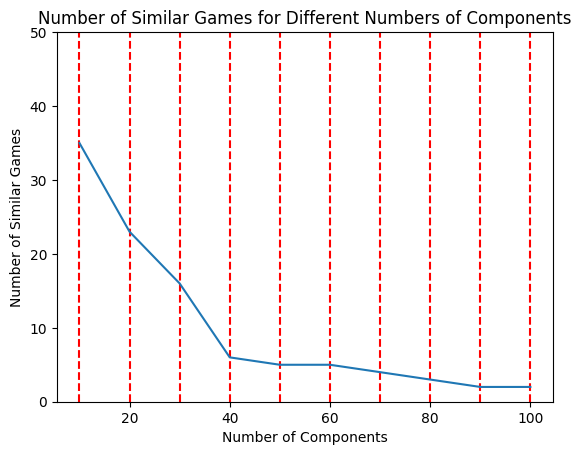

In [39]:
### PARAMETERS OF THE RECOMMENDER SYSTEM ###

input_app_id = 504230 # Go in games.csv, and pick an app_id to compute its similar games
threshold = 0.55
threshold_step = 0.05
game_recommendation_limit = 15
game_recommendation_requirement = 5

### HOW MUCH TAGS MUST WE MERGE INTO ONE CONCEPT ? ###

execute_comparison_visualisation = True
if (execute_comparison_visualisation):
    compare_components(df_game_tags_binary,df_app_id, input_app_id, threshold, std_multiplier)

# In this visualization, we see that 50~60 tags into one concept seems to be good choice in order to obtain good results.

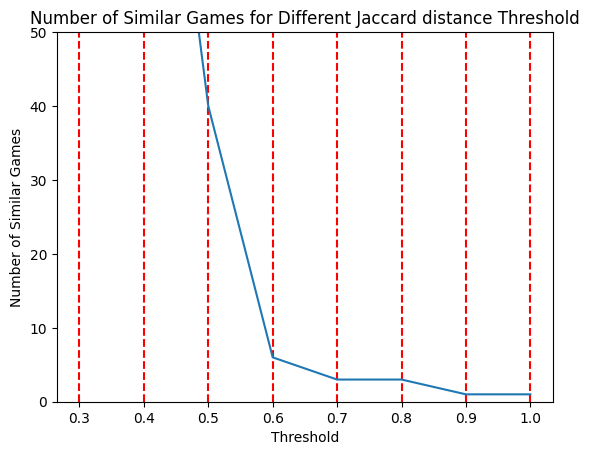

In [40]:
compare_threshold(df_svd, input_app_id, num_components)

In [10]:
### COMPUTING THE RECOMMENDATIONS ###

similar_games = []
while ((len(similar_games) > game_recommendation_limit) or (len(similar_games) < game_recommendation_requirement)):
    
    similar_games = find_similar_games(df_svd, input_app_id, threshold)
    similar_games.remove(input_app_id)

    # Modify the theshold if the results are not satisfying
    if (len(similar_games) < game_recommendation_requirement):
        threshold = round(threshold - threshold_step, 2)
        print("Found no games with the current threshold. Retrying with a smaller threshold = "+str(threshold))
    elif (len(similar_games) > game_recommendation_limit):
        threshold = round(threshold + threshold_step, 2)
        print("Found too much games ("+str(len(similar_games))+") with the current threshold. Retrying with a higher threshold = "+str(threshold))
    else :
        print("Found "+ str(len(similar_games))+ " similar games with threshold = " + str(threshold) )


# Retrieve the titles based on the app_ids
input_game = title = df_tags.loc[df_tags['app_id'] == input_app_id, 'title'].values[0]
output_games_list = df_tags.loc[df_tags['app_id'].isin(similar_games), 'title'].tolist()

# Display the results
print("Because you played \"" + input_game + "\", we recommend you the following games :")
for recommended_game in output_games_list:
    print("- "+ recommended_game)

Found too much games (175) with the current threshold. Retrying with a higher threshold = 0.55
Found too much games (22) with the current threshold. Retrying with a higher threshold = 0.6
Found too much games (22) with the current threshold. Retrying with a higher threshold = 0.65
Found 12 similar games with threshold = 0.65
Because you played "Celeste", we recommend you the following games :
- DREAMWILD
- Haiku the Robot
- Aeon Drive
- Cave Story+
- Taimumari: Definitive Edition
- Drive
- DOOMED
- SORE
- Creatures Inc
- Lorera
- Colorless World
- Pages of Time: Prologue
